In [112]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
plt.style.use('dark_background')

---
# Defining functions

In [113]:
@njit
def check_pos(n, random_pos, pos_list, rad):
    ''' Checks if two generated bodies are on top of one another to start with.
    This is to avoid immediate collisions & accelerations going to infinity. '''
    for index, pos in enumerate(pos_list):
        dist = np.sqrt((pos[0] - random_pos[0])**2 + (pos[1] - random_pos[1])**2)
        if dist * 1.5e11 < (rad[n] + rad[index]):
            return False
    return True

In [114]:
@njit
def gen_pos(n_bodies, pos, rad, pos_range):
    ''' Generate random position for n_bodies, fills up pos '''
    pos_min, pos_max = pos_range
    for n in range(n_bodies):
        accept_pos = False
        while accept_pos == False:
            random_pos = np.random.uniform(pos_min, pos_max, 2)
            accept_pos = check_pos(n, random_pos, pos, rad)
            if accept_pos == True:
                pos[n] = random_pos
    
    return pos * 1.5e11 # convert from AU to m (SI)

In [115]:
@njit
def gen_vel(n_bodies, vel, v_range):
    ''' Generates intial velocities in the v_range '''
    v_min, v_max = v_range
    for n in range(n_bodies):
        vel[n] = np.random.uniform(v_min, v_max, 2)
    
    return vel

In [116]:
@njit
def get_init(n_bodies, pos_range=(-25, 25), v_range=(-7e3, 7e3)):
    ''' Generates initial conditions. 
    n_bodies is the amount of bodies, obviously,
    pos_range determines the range of positions initially given to bodies, default: +/- 25 AU
    25 AU seems like a reasonable distance for objects of stellar mass to move in
    v_range determines the range of velocities initially given to bodies, default: +/- 7,000 m/s 
    returns matrices of positions and velocities (n, 2), where 2 is the number of dimensions - up to 3 if adding a 3rd dimension
            as well as arrays of mass and radius of each body (n length)
            all in SI units, hopefully
    '''
    m = np.random.uniform(1, 1500, n_bodies) / 10  # random mass between 0.1 and 150 solar masses
    rad = m**0.8  # estimate the radius based on mass in solar units
    m *= 2e30  # convert to SI
    rad *= 7e8  # convert to SI
    
    pos = np.zeros((n_bodies, 2))
    pos = gen_pos(n_bodies, pos, rad, pos_range)
    
    vel = np.zeros((n_bodies, 2))
    vel = gen_vel(n_bodies, vel, v_range)
    
    return pos, vel, m, rad  # units: m, m/s, kg, m

In [117]:
@njit
def get_dist(pos_list, index, i):
    ''' Calculates the distance between two points in the pos_list based on their indices. '''
    dx = pos_list[index, 0] - pos_list[i, 0]
    dy = pos_list[index, 1] - pos_list[i, 1]
    return np.sqrt( dx**2 + dy**2 )

In [118]:
@njit
def get_acc(acc, body, pos, m, G = 6.6743e-11):
    ''' Calculates acceleration (x, y) for one object based on its distance to all other objects in the pos list.
    acc is the acceleration vector, body is the index for the selected body in the list
    pos is the list of positions, m is the list of masses, G is the gravitational constant, default: 6.6743e-11
    '''
    for i in range(len(pos)):
        if body != i:
            r = get_dist(pos, body, i)
            acc[0] = G * m[i] / r**3 * (pos[i, 0] - pos[body, 0])
            acc[1] = G * m[i] / r**3 * (pos[i, 1] - pos[body, 1])
    return acc

In [134]:
def step(pos, vel, acc, m, rad, steps, dt, escape_lim = 50, speed_limit = False, periodic = False):
    ''' function that updates the position of each body each timestep 
    checks for collissions, optionally checks if any body is passing light speed, 
    and if any body is exceeding the simulation limits: if periodic is true, moves the body to the opposite side of the sim.
    '''
    tf = 0
    for t in range(steps-1):  # run through every timestep
        for body in range(len(pos)):  # for every body
            # Calculate acceleration for next timestep
            acc[body, :, t+1] = get_acc(acc[body, :, t], body, pos[:, :, t], m)
            
            # Calculating velocity
            next_v = vel[body, :, t] + acc[body, :, t] * dt  # velocity for next step
            if speed_limit:
                if np.sqrt(next_v[0]**2 + next_v[1]**2) < 3e8:  # only update if speed is lower than c (3e8)
                    vel[body, :, t+1] = next_v
            elif speed_limit != True:
                vel[body, :, t+1] = next_v
            
            # Calculating position
            pos[body, :, t+1] = pos[body, :, t] + vel[body, :, t] * dt  # position for next step
            
            # Check if any body has escaped
            if np.where(np.abs(pos[body, :, t+1]) > escape_lim * 1.5e11, True, False).any():  
                tf = t
                if periodic:  # if periodic universe
                    if np.abs(pos[body, 0, t+1]) > escape_lim * 1.5e11:  # x-direction loop-back
                        pos[body, 0, t+1] = -1 * np.sign(pos[body, 0, t+1]) * escape_lim * 1.5e11
                        print(f'Body {body} has looped. Pos_x set to {pos[body, 0, t+1]/1.5e11} from {pos[body, 0, t]/1.5e11} ({np.sign(pos[body, 0, t+1])})')
                    
                    if np.abs(pos[body, 1, t+1]) > escape_lim * 1.5e11:  # y-direction loop-back
                        pos[body, 1, t+1] = -1 * np.sign(pos[body, 1, t+1]) * escape_lim * 1.5e11
                        print(f'Body {body} has looped. Pos_y set to {pos[body, 1, t+1]/1.5e11} from {pos[body, 1, t]/1.5e11} ({np.sign(pos[body, 1, t+1])})')
                
                elif periodic != True:
                    print(f'Stop at t = {t} of {steps}: Body {body} ejected, final pos at ({np.round(pos[body, 0, t+1]/1.5e11,2)}, {np.round(pos[body, 1, t+1]/1.5e11)}) AU')
                    return pos, vel, m, rad, tf  # units: m, m/s, solar mass, solar radius, _
            
            # Check if any bodies have collided
            for other_body in range(len(pos)):
                if body != other_body:
                    dist = np.sqrt( (pos[body, 0, t] - pos[other_body, 0, t])**2 + (pos[body, 1, t] - pos[other_body, 1, t])**2 )
                    if dist < (rad[body] + rad[other_body]):
                        tf = t
                        print(f'Stop at t = {t} of {steps}: Collision between body {body} and {other_body}')
                        return pos, vel, m, rad, tf  # units: m, m/s, solar mass, solar radius, _
    
    return pos, vel, m, rad, tf  # units: m, m/s, solar mass, solar radius, _

In [120]:
def write_outfile(outfile, n, pos, vel, m, rad):
    ''' Writes initial conditions to a text file with a given name. '''
    f = open(f'{outfile}.txt', 'w')
    f.write(f'Initial conditions: #, m, rad, (x, y), (vx, vy) \n')
    for ns in range(n):
        f.write(f'Object {ns} with {m[ns]/2e30:.2f} solar masses and {rad[ns]/7e8:.2f} solar radii, ')
        f.write(f'at pos: ({pos[ns, 0, 0]:.1f}, {pos[ns, 1, 0]:.1f}) AU, ')
        f.write(f'v: ({vel[ns, 0, 0]:.2f}, {vel[ns, 1, 0]:.2f}) m/s\n')
    f.close()

In [121]:
def main(n = 3, steps = 50, dt = 1, infile = None, outfile = None, speed_limit = True, periodic = False):  # add outfile='initialconditions' for file
    ''' Main function to run simulation.
    n is the amount of bodies, steps is how many timesteps, dt is the stepsize
    outfile is the string name for a text file to write initial conditions to
    simple explanation is: generate empty arrays of dimensions (n, 2, steps), so:
    nr. of bodies, nr. of dimensions (2), and nr. of timesteps.
    insert initial values -> update for every step in t by calculating acceleration -> velocity -> position with the step function
    returns values in astronomical units (AU, m/s, solar mass, solar radii)
    '''
    pos = np.zeros((n, 2, steps))
    vel = np.zeros((n, 2, steps))
    acc = np.zeros((n, 2, steps))
    
    if not infile:
        pos[:, :, 0], vel[:, :, 0], m, rad = get_init(n)
    elif infile:
        pos[:, :, 0], vel[:, :, 0], m, rad = infile
    
    pos, vel, m, rad, tf = step(pos, vel, acc, m, rad, steps, dt, speed_limit = speed_limit, periodic = periodic)
    
    if outfile:
        write_outfile(outfile, n, pos, vel, m, rad)  # writes the initial conditions to a text file
    
    return pos/1.5e11, vel, m/2e30, rad/7e8, tf # units: AU, m/s, solar mass, solar radius, _

In [122]:
# Generate random simulation that lasts 0.75 * steps, at least
n = 3
steps = 2500
dt = 3e-3 * 365 * 24 * 60 * 60
tf = 0
pos, vel, m, rad, tf = main(n, steps, dt)
attempts = 0
while tf < steps * 0.75:
    pos, vel, m, rad, tf = main(n, steps, dt)
    attempts += 1
print(f'Found a sim in {attempts} attempts!')

Stop at t = 628 of 2500: Collision between body 1 and 2
Stop at t = 108 of 2500: Collision between body 1 and 2
Stop at t = 1093 of 2500: Body 0 ejected, final pos at (19.98, -100.0) AU
Stop at t = 148 of 2500: Collision between body 1 and 2
Stop at t = 2342 of 2500: Body 2 ejected, final pos at (31.85, -100.0) AU
Found a sim in 4 attempts!


---
# Gif creation

In [123]:
from celluloid import Camera

In [124]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, 2*n)
cmap = get_cmap(n)

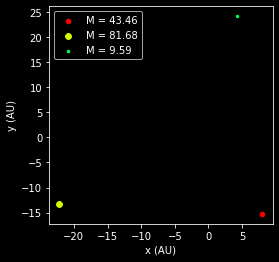

In [125]:
# Plot initial condition:
fig = plt.figure(figsize=(4, 4))
for n_body in range(n):
    plt.scatter(pos[n_body, 0, 0], pos[n_body, 1, 0], s=rad[n_body], color=cmap(n_body), label=f'M = {m[n_body]:.2f}')
plt.legend()
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


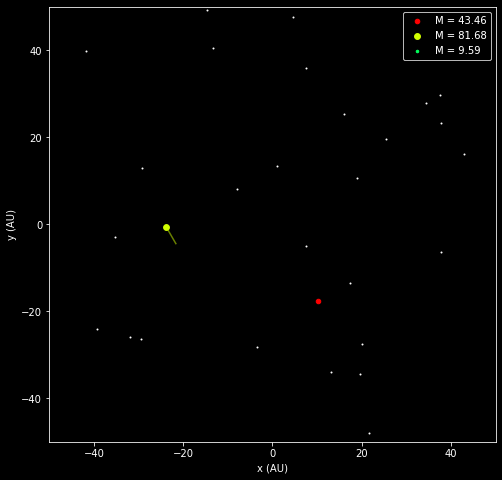

In [126]:
# Create gif
fig = plt.figure(figsize=(8, 8))
camera = Camera(fig)
plt.xlim(-50, 50)
plt.ylim(-50, 50)

# Background stars
x, y = np.random.uniform(-50, 50, n**3), np.random.uniform(-50, 50, n**3)
tail = int(tf/10)

report_freq = steps/100
for t in range(tf):
    if t % report_freq == 0:
        plt.scatter(x,  y, s=1, color='white')
        for n_body in range(n):
            if t == 0:
                plt.scatter(pos[n_body, 0, t], pos[n_body, 1, t], s=rad[n_body], color=cmap(n_body), label=f'M = {m[n_body]:.2f}')
            elif t != 0:
                plt.scatter(pos[n_body, 0, t], pos[n_body, 1, t], s=rad[n_body], color=cmap(n_body))
            prev_pos = pos[n_body, :, int(max(t - tail, 0)):t + 1]
            plt.plot(prev_pos[0], prev_pos[1], alpha=1/2, color=cmap(n_body))
        
        plt.legend()
        plt.xlabel('x (AU)')
        plt.ylabel('y (AU)')
        camera.snap()

animation = camera.animate(interval=30)
animation.save('nbody.gif')

---
# Figure 8

In [127]:
# Attempt at creating the figure-8 stable 3-body configuration
n = 3
steps = 3000
dt = 1e5

# Create initial conditions as initfile
pos0 = np.array([[-1, 0], [1, 0], [0, 0]]) * 1.5e11
p1, p2 = 0.347111, 0.532728
vel0 = np.array([[p1, p2], [p1, p2], [-2*p1, -2*p2]])
vel0 *= 7e3
m0 = np.array([1, 1, 1])*2e29
rad0 = m**0.8
initfile = pos0, vel0, m0, rad0
# Create entire simulation
pos, vel, m, rad, tf = main(n, steps, dt, infile=initfile)

# Background stars
minx, miny, maxx, maxy = np.min(pos[:, 0, :]), np.min(pos[:, 1, :]), np.max(pos[:, 0, :]), np.max(pos[:, 1, :])
x, y = np.random.uniform(minx, maxx, n**4), np.random.uniform(miny, maxy, n**4)


MovieWriter ffmpeg unavailable; using Pillow instead.


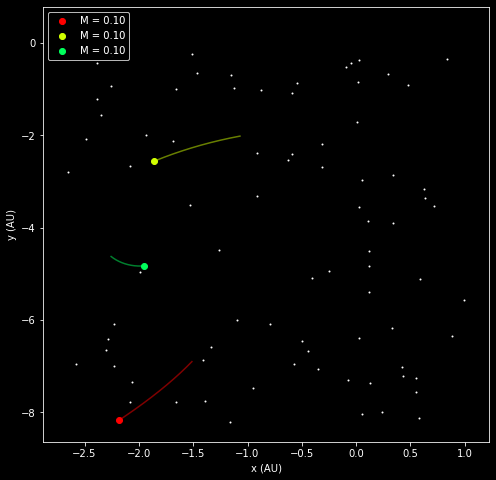

In [128]:
# Create figure-8 gif
fig = plt.figure(figsize=(8, 8))
camera = Camera(fig)

tail = int(steps/10)

report_freq = steps/100
for t in range(steps):
    if t % report_freq == 0:
        plt.scatter(x, y, s = 1, c='white')
        for n_body in range(n):
            if t == 0:
                plt.scatter(pos[n_body, 0, t], pos[n_body, 1, t], color=cmap(n_body), label=f'M = {m[n_body]:.2f}')
            elif t != 0:
                plt.scatter(pos[n_body, 0, t], pos[n_body, 1, t], color=cmap(n_body))
            prev_pos = pos[n_body, :, int(max(t - tail, 0)):t + 1]
            plt.plot(prev_pos[0], prev_pos[1], alpha=1/2, color=cmap(n_body))
        
        plt.legend(loc='upper left')
        plt.xlabel('x (AU)')
        plt.ylabel('y (AU)')
        camera.snap()

animation = camera.animate(interval=20)
animation.save('figure8.gif')

---
# Periodic Universe

In [135]:
n = 3
steps = 2500
dt = 3e-3 * 365 * 24 * 60 * 60
tf = 0
pos, vel, m, rad, tf = main(n, steps, dt, periodic = True)
if tf < steps * 0.75:
    print('Doing another attempt')

attempts = 0
while tf < steps * 0.75:
    pos, vel, m, rad, tf = main(n, steps, dt, periodic = True)
    attempts += 1
print(f'Found a sim in {attempts} attempts!')

Stop at t = 559 of 2500: Collision between body 1 and 2
Doing another attempt
Stop at t = 398 of 2500: Collision between body 1 and 2
Body 0 has looped. Pos_y set to 50.0 from -49.80754733398717 (1.0)
Body 0 has looped. Pos_x set to 50.0 from -49.93296297078567 (1.0)
Body 0 has looped. Pos_y set to 50.0 from -49.76478980359408 (1.0)
Body 2 has looped. Pos_x set to -50.0 from 49.878108320027955 (-1.0)
Body 1 has looped. Pos_y set to 50.0 from -49.90184064631371 (1.0)
Body 2 has looped. Pos_y set to -50.0 from 49.775422666561546 (-1.0)
Body 1 has looped. Pos_x set to 50.0 from -49.99694306664129 (1.0)
Body 0 has looped. Pos_x set to 50.0 from -49.94166920567308 (1.0)
Body 0 has looped. Pos_y set to 50.0 from -49.9970715066718 (1.0)
Body 2 has looped. Pos_x set to -50.0 from 49.79116488077465 (-1.0)
Body 2 has looped. Pos_y set to -50.0 from 49.90220672751472 (-1.0)
Body 0 has looped. Pos_y set to 50.0 from -49.98002871080446 (1.0)
Body 1 has looped. Pos_x set to 50.0 from -49.81910187584

MovieWriter ffmpeg unavailable; using Pillow instead.


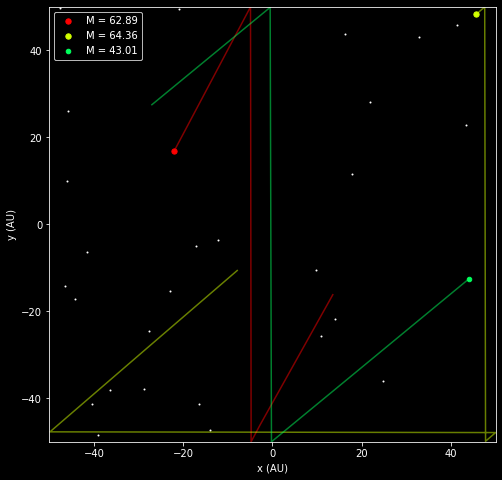

In [136]:
fig = plt.figure(figsize=(8, 8))
camera = Camera(fig)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
# Background stars
x, y = np.random.uniform(-50, 50, n**3), np.random.uniform(-50, 50, n**3)
tail = int(tf/10)

report_freq = steps/100
for t in range(tf):
    if t % report_freq == 0:
        plt.scatter(x,  y, s=1, color='white')
        for n_body in range(n):
            if t == 0:
                plt.scatter(pos[n_body, 0, t], pos[n_body, 1, t], s=rad[n_body], color=cmap(n_body), label=f'M = {m[n_body]:.2f}')
            elif t != 0:
                plt.scatter(pos[n_body, 0, t], pos[n_body, 1, t], s=rad[n_body], color=cmap(n_body))
            prev_pos = pos[n_body, :, int(max(t - tail, 0)):t + 1]
            plt.plot(prev_pos[0], prev_pos[1], alpha=1/2, color=cmap(n_body))
        
        plt.legend(loc='upper left')
        plt.xlabel('x (AU)')
        plt.ylabel('y (AU)')
        camera.snap()

animation = camera.animate(interval=30)
animation.save('periodic.gif')